# セットアップ
base (Python 3.8.5)で実行．エクスプローラーでprojectを開く必要あり．

In [1]:
from datetime import date,timedelta
import pandas as pd
import numpy as np
import io
import pickle
import re
%matplotlib inline
import matplotlib.pyplot as plt
import openpyxl
import networkx as nx
from pyvis.network import Network
import community

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# pd.options.display.max_colwidth = 50

df_capital = pd.read_excel("capital_20220130.xlsx")
df_company = pd.read_excel("company_20220130.xlsx")
df_equity = pd.read_excel("equity_20220130.xlsx", index_col = 0)

In [40]:
# ioをimportする必要あり
def info_with_value(df, num_values_max = 5):
    # infoの内容を文字列のリストで取得
    buffer = io.StringIO()
    df.info(buf = buffer)
    info_list = buffer.getvalue().split("\n")
    # 必要な情報を付け足す
    num_values_max = min(num_values_max, len(df))
    str_to_append = ": "
    info_list[3] = info_list[3] + str_to_append + "Values"
    info_list[4] = info_list[4] + str_to_append + "------"
    num_columns = len(df.columns) # 何列分付け足すか決める
    idx_start = len(info_list) - 3 - num_columns # スタート位置は可変

    for i in range(idx_start, idx_start + num_columns, 1):
        info_list[i] = info_list[i] + str_to_append + " ".join(df.iloc[: num_values_max, i - idx_start].astype("str"))

    for text in info_list:
        print(text)

In [41]:
info_with_value(df_capital)
info_with_value(df_company)
info_with_value(df_equity)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41579 entries, 0 to 41578
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  : Values
---  ------              --------------  -----  : ------
 0   code                41579 non-null  object : E03531 E03531 E03531 E03531 E03531
 1   type                41579 non-null  object : specified specified specified specified specified
 2   name_of_securities  41568 non-null  object : イオン HO CHI MINH CITY DEVELOPMENT JOINT STOCK COMMERCIAL BANK 日本電子 兼松 プレミアグループ
 3   purpose             41109 non-null  object : 取引関係の維持・強化のために保有しております。 取引関係の維持・強化のために保有しております。なお、株式数の増加は株式配当によるものです。 取引関係の維持・強化のために保有しております。 取引関係の維持・強化のために保有しております。 取引関係の維持・強化のために保有しております。
 4   held                41547 non-null  object : 無 無 無 無 無
 5   number              41577 non-null  float64: 500000.0 11709848.0 250000.0 700000.0 258600.0
 6   book_value          41579 non-null  int64  : 1649000000 1483000000 1097000000 1040000000 624000000
dtypes: floa

# データクレンジング

全角と半角を変換するための準備

In [42]:
ZEN = "".join(chr(0xff01 + i) for i in range(94))
HAN = "".join(chr(0x21 + i) for i in range(94))
ZEN2HAN = str.maketrans(ZEN, HAN)

In [43]:
# スペースや改行などの不要な要素を削除する
def remove_spaces(names):
    names = names.str.replace("\n", "")
    names = names.str.replace("\xa0", "")
    names = names.str.replace(" ", "")
    names = names.str.replace("　", "")
    # names = names.str.replace(",", "")
    return names

# 注や株式会社などの表示を削除する
def remove_annotations(names):
    names = names.str.replace("株式会社", "")
    names = names.str.replace("㈱", "")
    names = names.str.replace("\(株\)", "")
    names = names.str.replace(r"\(\)", "")
    names = names.str.replace("（株）", "")
    names = names.str.replace("\(株）", "")
    names = names.str.replace("（株\)", "")
    names = names.str.replace("株式", "")
    
    names = names.str.replace("\(持株会\)", "")
    names = names.str.replace("（持株会）", "")
    names = names.str.replace("／持株会", "")
    names = names.str.replace("持株会", "")
    names = names.str.replace("持ち株会", "")
    
    names = names.str.replace("\(普通株式\)", "")
    names = names.str.replace("（普通株式）", "")
    names = names.str.replace("●", "")
    
    # 伊藤園は優先株を発行しているためややこしい
    names = names.str.replace("伊藤園(.*)", "伊藤園", regex = True)
    
    names = names.str.replace("（注(.*)", "")
    names = names.str.replace("\(注(.*)", "")
    
    names == names.str.replace("\(※.\)", "")
    names = names.str.replace("※(.)", "")
    names = names.str.replace("(.*)※", r"\1")
    
    return names

def align_name(names):
    names = names.str.replace("フィナンシャル・グループ", "FG")
    names = names.str.replace("フィナンシャルグループ", "FG")
    names = names.str.replace("フィナンシャルグル-プ", "FG") # 頭おかしい
    names = names.str.replace("髙", "高") # 高島屋対策
    names = names.str.replace("ジェイエフイー", "JFE") # JFEホールディングス対策
    names = names.str.replace("瓦斯", "ガス") # ガス会社はそろっていない
    names = names.str.replace("マツモトキヨシホールディングス", "マツキヨココカラ&カンパニー")
    names = names.str.translate(ZEN2HAN) # 全角を半角に変換
    return names
    

df_capital["name_of_securities"] = remove_spaces(df_capital["name_of_securities"])
df_capital["name_of_securities"] = remove_annotations(df_capital["name_of_securities"])
df_capital["name_of_securities"] = align_name(df_capital["name_of_securities"])
df_company["銘柄名"] = remove_spaces(df_company["銘柄名"]) # 企業名の名簿も変換する必要あり
df_company["銘柄名"] = align_name(df_company["銘柄名"])


C:\UserTmp\ipykernel_15212\3913550949.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace("\(株\)", "")
C:\UserTmp\ipykernel_15212\3913550949.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace(r"\(\)", "")
C:\UserTmp\ipykernel_15212\3913550949.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace("\(株）", "")
C:\UserTmp\ipykernel_15212\3913550949.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace("（株\)", "")
C:\UserTmp\ipykernel_15212\3913550949.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace("\(持株会\)", "")
C:\UserTmp\ipykernel_15212\3913550949.py:27: FutureWarning: The default value of regex will change f

# データの結合

In [44]:
# 自己資本の情報をくっつける
df_capital = pd.merge(df_capital, df_equity, left_on = "code", right_index = True, how = "left")

# 株式を保有している企業(from)の情報をくっつける
df_capital = pd.merge(df_capital, df_company[["ＥＤＩＮＥＴコード", "銘柄名"]], left_on = "code", right_on = "ＥＤＩＮＥＴコード", how = "left")
df_capital.drop( "ＥＤＩＮＥＴコード", axis = 1)
df_capital.rename(columns = {"銘柄名": "from"}, inplace = True)

# 株式を保有されている企業(to)の情報も追加
df_capital = pd.merge(df_capital, df_company["銘柄名"], left_on = "name_of_securities", right_on = "銘柄名", how = "left")
df_capital.rename(columns = {"銘柄名": "to"}, inplace = True)

# 有価証券報告書に企業名が載っていないような場合を落とす
df_capital.dropna(subset = ["name_of_securities"], inplace = True)

# toがうまくくっつかなかった企業をリストアップ，件数をカウント
to_na_list = df_capital["to"].isna()
to_na_list.sum()

2754

# もう少し整形

後ろに`hoge`がつく可能性を考える

In [45]:
suffix_list = ["ホールディングス", "FG", "工業", "グループ", "ス"]
suffix_bank_list = ["FG", "フィナンシャルホールディングス"]
for idx in to_na_list.index:
    if to_na_list[idx]: # 銘柄名がうまくくっつかなかったデータ
        name = df_capital.at[idx, "name_of_securities"]
        
        # suffixをつけると企業名が見当たる場合
        for suffix in suffix_list:
            name_with_suffix = name + suffix
            if name_with_suffix in df_company["銘柄名"].values:
                df_capital.at[idx, "to"] = name_with_suffix
                print(name_with_suffix)
        
        # 銀行の場合，適当に名前を修正する必要がある可能性
        if name[len(name)-2:] == "銀行":
            for suffix in suffix_bank_list:
                name_replaced = name[:-2] + suffix
                if name_replaced in df_company["銘柄名"].values:
                    df_capital.at[idx, "to"] = name_replaced
                    print(name_replaced)

ニッコンホールディングス
北國フィナンシャルホールディングス
ソニーグループ
沖電気工業
西部ガスホールディングス
エムアップホールディングス
北國フィナンシャルホールディングス
あすか製薬ホールディングス
エムアップホールディングス
北國フィナンシャルホールディングス
十六FG
楽天グループ
十六FG
十六FG
十六FG
十六FG
ソニーグループ
クワザワホールディングス
日本光電工業
北國フィナンシャルホールディングス
十六FG
ソフトクリエイトホールディングス
バローホールディングス
十六FG
ソニーグループ
鳥貴族ホールディングス
バローホールディングス
メディカル一光グループ
西部ガスホールディングス
アイ・ケイ・ケイホールディングス
十六FG
十六FG
コナミホールディングス
北國フィナンシャルホールディングス
十六FG
北國フィナンシャルホールディングス
ソフトクリエイトホールディングス
コメ兵ホールディングス
十六FG
北國フィナンシャルホールディングス
十六FG
電算システムホールディングス
ソニーグループ
十六FG
ソニーグループ
北國フィナンシャルホールディングス
十六FG
十六FG
十六FG
ソニーグループ
十六FG
十六FG
あすか製薬ホールディングス
北國フィナンシャルホールディングス
日本マクドナルドホールディングス
十六FG
十六FG
北國フィナンシャルホールディングス
あすか製薬ホールディングス
北國フィナンシャルホールディングス
十六FG
北國フィナンシャルホールディングス
十六FG
北國フィナンシャルホールディングス
ソニーグループ
ソニーグループ
北國フィナンシャルホールディングス
ソニーグループ
十六FG
橋本総業ホールディングス
楽天グループ
ヤマウホールディングス
西部ガスホールディングス
十六FG
楽天グループ
北國フィナンシャルホールディングス
福井コンピュータホールディングス
十六FG
電算システムホールディングス
十六FG
東京電力ホールディングス
西部ガスホールディングス
西部ガスホールディングス
昭文社ホールディングス
ソニーグループ
ソニーグループ
西部ガスホールディングス
電算システムホールディングス
十六FG
十六FG
三菱自動車工業
電算システムホールディングス
十六FG
ソニーグループ
北國フィナン

In [46]:
# toがうまくくっつかなかった企業数がどの程度改善しているか確認
to_na_list = df_capital["to"].isna()
to_na_list.sum()

2479

うまくくっつかなかった企業の多くは①名証，②企業名変更，③上場廃止，のいずれかに該当しているため，あまり問題はなさそう．

In [47]:
df_capital[to_na_list]["name_of_securities"].value_counts().to_frame().head(20)

,name_of_securities
岡谷鋼機,82
マルイチ産商,54
ヤマナカ,48
関西みらいFG,48
ヤマエ久野,47
セントラルフォレストグループ,45
御園座,43
前田建設工業,41
協和エクシオ,38
日本通運,35


# 基礎統計調査

株式を保有している企業(from)について，銘柄数と簿価のそれぞれでランキングを表示

In [48]:
df_capital.groupby("from").size().rename("銘柄数").to_frame().sort_values("銘柄数", ascending = False).head(10).style.bar()

,銘柄数
from,
伊予銀行,139
百五銀行,74
京都銀行,72
住友不動産,71
中国銀行,71
大日本印刷,66
日新,65
八十二銀行,65
長瀬産業,65


In [49]:
df_capital.groupby("from")[["book_value"]].sum().rename(columns = {"book_value": "簿価"}).sort_values("簿価", ascending = False).head(10) / 100000000

,簿価
from,
トヨタ自動車,26338.82
京セラ,12162.99
京都銀行,11494.75
三井物産,10574.62
豊田自動織機,9079.17
デンソー,7216.52
三井不動産,6581.09
三菱重工業,5587.02
三菱商事,5457.27


Text(0, 0.5, '企業数')

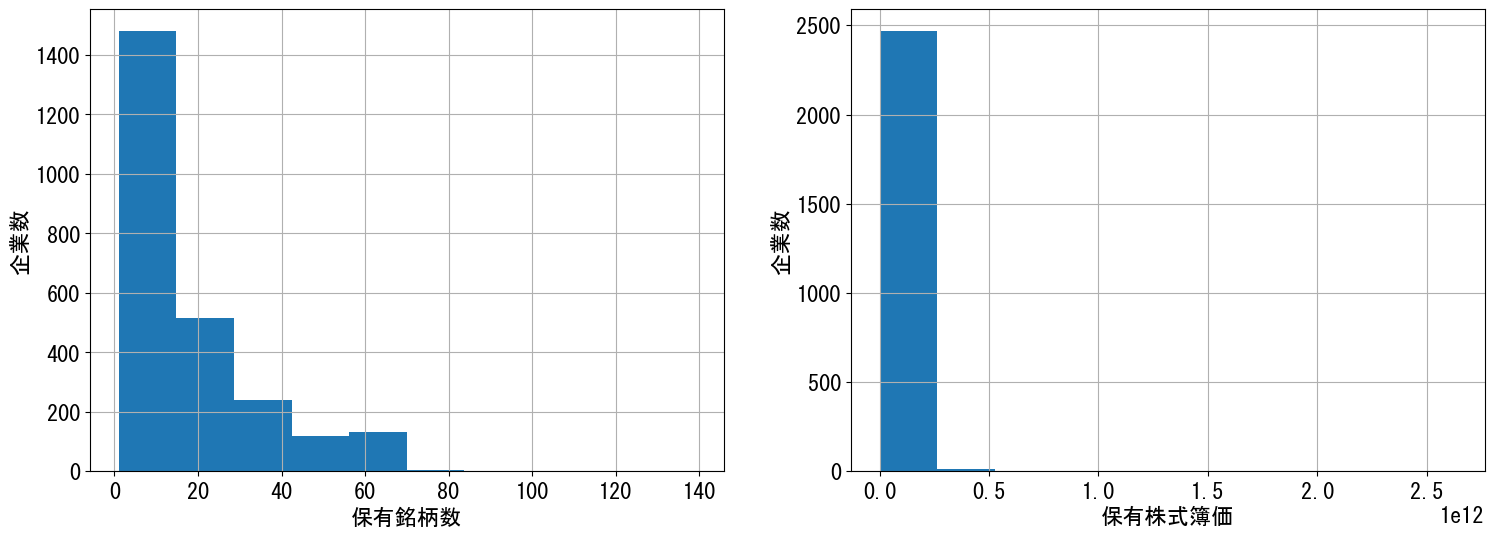

In [50]:
plt.rcParams["font.family"] = "MS Gothic"
plt.rcParams["font.size"] = 16
plt.figure(figsize = (18, 6))

plt.subplot(1, 2, 1)
df_capital.groupby("from").size().hist()
plt.xlabel("保有銘柄数")
plt.ylabel("企業数")

plt.subplot(1, 2, 2)
df_capital.groupby("from").sum()["book_value"].hist()
plt.xlabel("保有株式簿価")
plt.ylabel("企業数")

(array([1.479e+03, 5.160e+02, 2.390e+02, 1.180e+02, 1.340e+02, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  14.8,  28.6,  42.4,  56.2,  70. ,  83.8,  97.6, 111.4,
        125.2, 139. ]),
 <BarContainer object of 10 artists>)

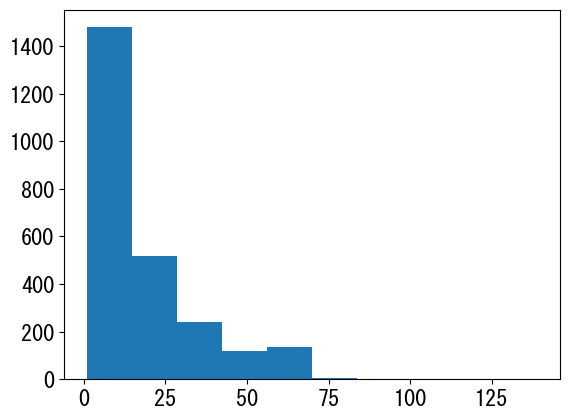

In [51]:
num_list = df_capital.groupby("from").size().values
book_value_list = df_capital.groupby("from").sum()["book_value"].values / 100000000
plt.hist(num_list)

株式を保有されている企業(to)について，銘柄名と簿価のそれぞれでランキングを表示

In [52]:
df_capital.groupby("to").size().rename("銘柄数").to_frame().sort_values("銘柄数", ascending = False).head(10)

,銘柄数
to,
三菱UFJFG,1133
みずほFG,943
三井住友FG,744
三井住友トラスト・ホールディングス,511
第一生命ホールディングス,346
りそなホールディングス,342
MS&ADインシュアランスグループホールディングス,231
住友不動産,225
東京海上ホールディングス,204


In [53]:
df_capital.groupby("to")[["book_value"]].sum().rename(columns = {"book_value": "簿価"}).sort_values("簿価", ascending = False).head(10) / 100000000

,簿価
to,
KDDI,23785.31005
トヨタ自動車,16967.73992
リクルートホールディングス,10484.05300
ダイキン工業,7753.58725
三菱UFJFG,7481.21711
デンソー,7322.41382
オリエンタルランド,7180.79654
日本電産,6600.79736
住友不動産,6009.07735


In [54]:
# まとめて出力
with pd.ExcelWriter("./result/基礎統計.xlsx") as writer:
    df_capital.groupby("from").size().rename("銘柄数").to_frame().sort_values("銘柄数", ascending = False).to_excel(writer, sheet_name = "銘柄数(from)")
    df_capital.groupby("from")[["book_value"]].sum().rename(columns = {"book_value": "簿価"}).sort_values("簿価", ascending = False).to_excel(writer, sheet_name = "簿価(from)")
    df_capital.groupby("to").size().rename("銘柄数").to_frame().sort_values("銘柄数", ascending = False).to_excel(writer, sheet_name = "銘柄数(to)")
    df_capital.groupby("to")[["book_value"]].sum().rename(columns = {"book_value": "簿価"}).sort_values("簿価", ascending = False).to_excel(writer, sheet_name = "簿価(to)")
    df_capital.groupby("from")[["EQUITY"]].max().sort_values("EQUITY", ascending = False).to_excel(writer, sheet_name = "自己資本")


In [55]:
info_with_value(df_capital)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41566 entries, 0 to 41578
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  : Values
---  ------              --------------  -----  : ------
 0   code                41566 non-null  object : E03531 E03531 E03531 E03531 E03531
 1   type                41566 non-null  object : specified specified specified specified specified
 2   name_of_securities  41566 non-null  object : イオン HOCHIMINHCITYDEVELOPMENTJOINTSTOCKCOMMERCIALBANK 日本電子 兼松 プレミアグループ
 3   purpose             41104 non-null  object : 取引関係の維持・強化のために保有しております。 取引関係の維持・強化のために保有しております。なお、株式数の増加は株式配当によるものです。 取引関係の維持・強化のために保有しております。 取引関係の維持・強化のために保有しております。 取引関係の維持・強化のために保有しております。
 4   held                41546 non-null  object : 無 無 無 無 無
 5   number              41566 non-null  float64: 500000.0 11709848.0 250000.0 700000.0 258600.0
 6   book_value          41566 non-null  int64  : 1649000000 1483000000 1097000000 1040000000 624000000
 7   EQUITY        

# ネットワークの表示

In [60]:
df_network = df_capital[["from", "to", "book_value"]].copy()
df_network.rename(columns = {"from":"source", "to": "target", "book_value": "weight"}, inplace = True)
df_network.dropna(subset = ["source", "target"], inplace = True)
info_with_value(df_network)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39087 entries, 0 to 41578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype : Values
---  ------  --------------  ----- : ------
 0   source  39087 non-null  object: あおぞら銀行 あおぞら銀行 あおぞら銀行 あおぞら銀行 あおぞら銀行
 1   target  39087 non-null  object: イオン 日本電子 兼松 プレミアグループ ANAホールディングス
 2   weight  39087 non-null  int64 : 1649000000 1097000000 1040000000 624000000 257000000
dtypes: int64(1), object(2)
memory usage: 1.2+ MB



In [61]:
df_node_size = df_capital[["from", "EQUITY"]].copy()
df_node_size.rename(columns = {"from":"source", "EQUITY":"size"}, inplace = True)
df_node_size.dropna(subset = ["source"], inplace = True)
df_node_size.drop_duplicates(subset = "source", inplace = True)
info_with_value(df_node_size)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2491 entries, 0 to 41574
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  : Values
---  ------  --------------  -----  : ------
 0   source  2491 non-null   object : あおぞら銀行 あじかん あらた ありがとうサービス あんしん保証
 1   size    2483 non-null   float64: 494065000000.0 13228122000.0 91017000000.0 1916158000.0 2934617000.0
dtypes: float64(1), object(1)
memory usage: 58.4+ KB



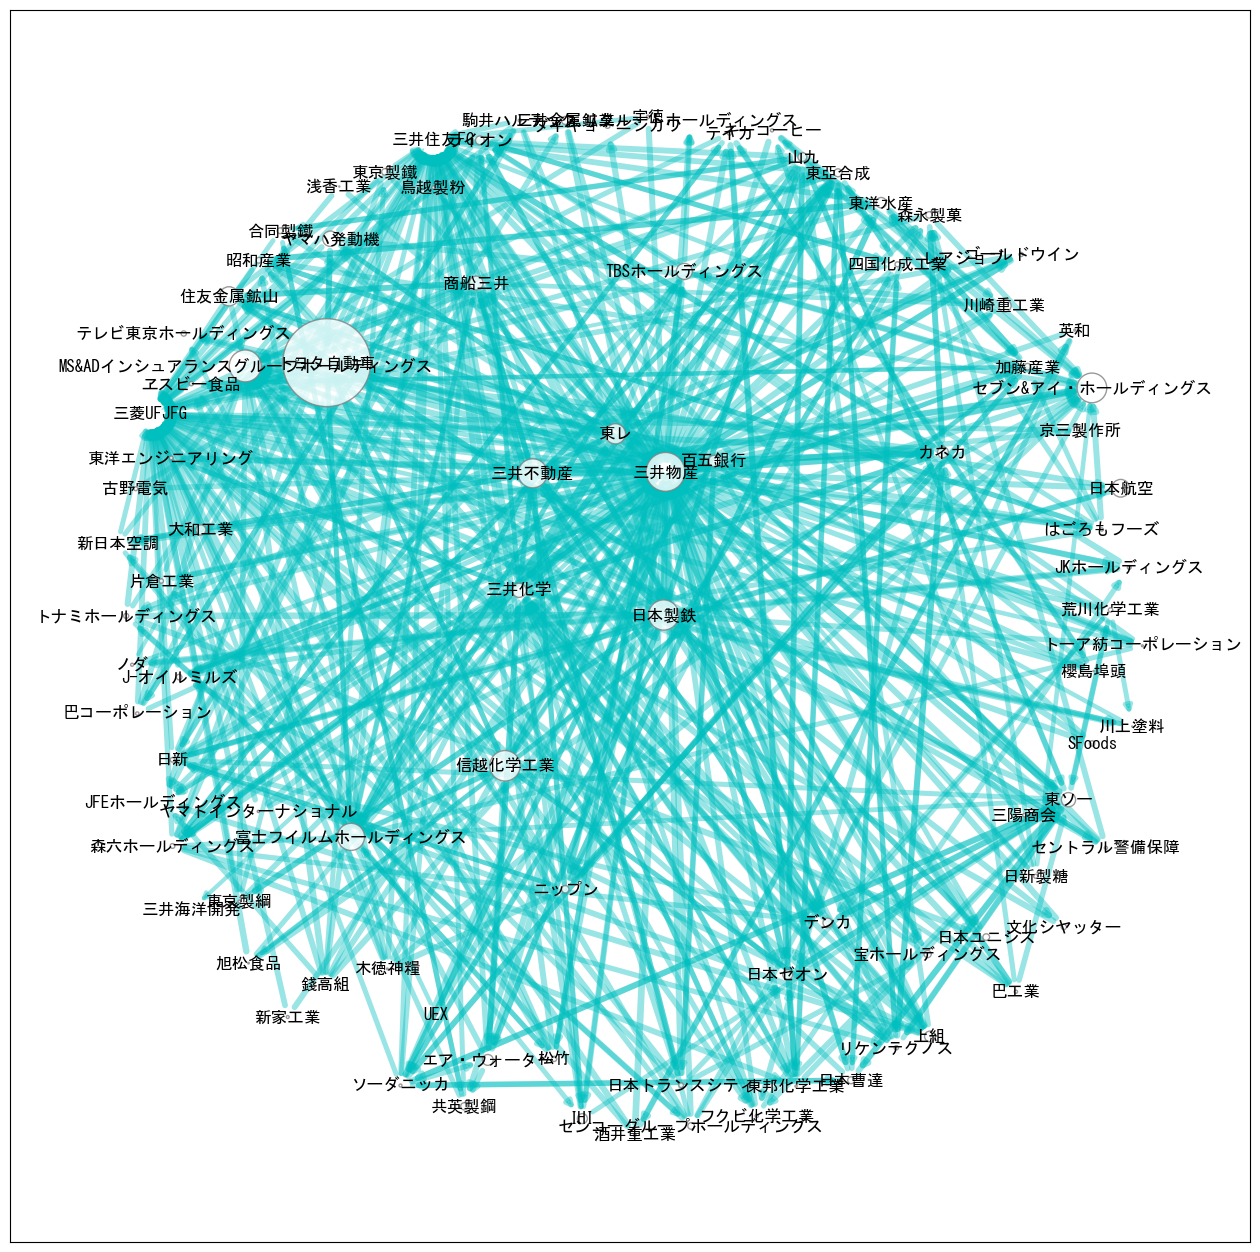

In [62]:
def scale_zero2one(values, scale):
    values = values - min(values)
    return values / max(values) * scale

plt.figure(figsize = (16, 16))

company_focus = "三井物産"
neighbor_list = []
neighbor_list.extend(df_network[(df_network["source"] == company_focus)]["target"].values) # 着目する企業が持っている企業
neighbor_list.extend(df_network[(df_network["target"] == company_focus)]["source"].values) # 着目する企業を持っている企業
neighbor_list = list(set(neighbor_list))

df_network_focus = df_network[(df_network["source"] == company_focus) | (df_network["target"] == company_focus)].copy() # 隣接エッジ
df_network_neighbor = df_network[df_network["source"].isin(neighbor_list) & df_network["target"].isin(neighbor_list)].copy() # 隣接企業の隣接エッジ 
df_network_focus = pd.concat([df_network_focus, df_network_neighbor]) # 距離が2であり，着目する企業と直接関係ある企業

G  = nx.from_pandas_edgelist(df_network_focus, edge_attr = True, create_using=nx.DiGraph())
position = nx.spring_layout(G, k = 2000)

epsilon = 0.01
nodes_scale = 4000.0

node_list = list([node for (node, value) in G.nodes(data = True)])
df_node_size_focus = pd.DataFrame(index = node_list)

df_node_size_focus = pd.merge(df_node_size_focus, df_node_size, how = "left", left_index = True, right_on = "source")
df_node_size_focus.fillna({"size": 0.0}, inplace = True)

# node_size = np.log(epsilon + df_node_size_focus["size"].values)
node_size = df_node_size_focus["size"].values
node_size = scale_zero2one(node_size, nodes_scale)
nx.draw_networkx_nodes(G, position, node_color = "w", alpha = 0.8, node_size = node_size, edgecolors = "grey")
nx.draw_networkx_labels(G, position, font_family = "MS Gothic", font_weight = "bold")

edge_scale = 5.0
edge_width = np.log(epsilon + df_network_focus["weight"].values)
edge_width = scale_zero2one(edge_width, edge_scale)
nx.draw_networkx_edges(G, position, alpha=0.4, edge_color="c", width=edge_width)

plt.show()

In [181]:
G  = nx.from_pandas_edgelist(df_network, edge_attr = True, create_using=nx.DiGraph())
partition = community.best_partition(G)
nx.draw_networkx(G, node_color = list(partition.values()))
plt.show()

TypeError: Bad graph type, use only non directed graph

In [151]:
df_network_focus

,source,target,weight
6320,セレスポ,電通グループ,355000
8120,テレビ朝日ホールディングス,電通グループ,2840000000
8157,テー・オー・ダブリュー,電通グループ,922000
10199,ハードオフコーポレーション,電通グループ,1420000
10390,ヒビノ,電通グループ,4686000
...,...,...,...
41245,TBSホールディングス,富士フイルムホールディングス,3253000000
41247,TBSホールディングス,江崎グリコ,1902000000
41248,TBSホールディングス,ライオン,1420000000
41250,TBSホールディングス,歌舞伎座,726000000


In [109]:
node_size

array([ 81.60801876,  95.1056586 ,  62.55015419,  91.88074181,
       100.        ,  85.61134979,  88.10992344,  76.32271995,
        96.0086921 ,  87.88849294,  89.73467214,   0.        ,
        97.11542939,  91.67323221,  82.89242157,   0.        ,
         0.        ,   0.        ,  62.59048998,  95.02834649,
        90.58977814,  93.66024699,  79.50195322,  88.14713916,
        93.92967604,  81.6988359 ,  68.29190061,  78.18101245,
        74.42424658,  85.65664705,  87.70646037,  84.18925275,
        91.8313746 ,  94.22883725,  79.63384549,  81.78186638,
        95.55278897,  72.30641675,  79.70579518])

In [105]:
node_list = list([node for (node, value) in G.nodes(data = True)])
df_node_size = pd.DataFrame(index = node_list)

df_network_focus_grouped = df_network_focus.groupby("source").sum().copy()
df_node_size = pd.merge(df_node_size, df_network_focus_grouped, how = "left", left_index = True, right_on = "source")
df_node_size.fillna({"weight": 0.0}, inplace = True)
df_node_size

,source,weight
エクセディ,エクセディ,1.148000e+09
ヤマハ発動機,ヤマハ発動機,7.748400e+10
エンシュウ,エンシュウ,3.000000e+06
スタンレー電気,スタンレー電気,2.832400e+10
トヨタ自動車,トヨタ自動車,3.568770e+11
ミクニ,ミクニ,4.004000e+09
ミツバ,ミツバ,8.732000e+09
ヤマザキ,ヤマザキ,2.206230e+08
ヤマハ,ヤマハ,1.027060e+11
小糸製作所,小糸製作所,8.149000e+09


In [103]:
df_network_focus_grouped

,weight
source,
ASTI,634078000
KYB,26548000000
SUBARU,595000000
エクセディ,1148000000
エンシュウ,3000000
エーザイ,394000000
キヤノン,8834000000
ジェイテクト,1714000000
スズキ,75637000000


In [90]:
node_list

['エクセディ',
 'ヤマハ発動機',
 'エンシュウ',
 'スタンレー電気',
 'トヨタ自動車',
 'ミクニ',
 'ミツバ',
 'ヤマザキ',
 'ヤマハ',
 '小糸製作所',
 '日本精機',
 'ディジタルメディアプロフェッショナル',
 '静岡銀行',
 'KYB',
 'ジェイテクト',
 'みずほFG',
 '三井住友FG',
 '三菱UFJFG',
 '鳥羽洋行',
 'スズキ',
 'ブリヂストン',
 '本田技研工業',
 'SUBARU',
 'キヤノン',
 '三井物産',
 '日産自動車',
 '浜松ホトニクス',
 'エーザイ',
 '川崎重工業',
 'リョービ',
 '三ツ星ベルト',
 '今仙電機製作所',
 '住友ゴム工業',
 '住友商事',
 '小野測器',
 '日本トムソン',
 '日本製鉄',
 '遠州トラック',
 'ASTI']

In [94]:
print(len(node_list), len(df_network_focus_node_size))

39 35


In [95]:
df_network_focus[df_network_focus["source"] == "ディジタルメディアプロフェッショナル"]

,source,target,weight


(array([  7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          2.,  17.,  41., 107., 128., 125., 109.,  30.,   8.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

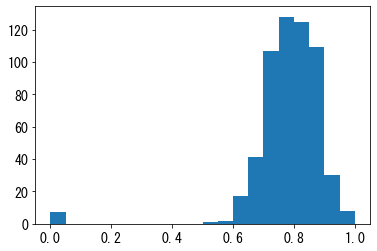

In [41]:
epsilon = 0.01
edge_width = np.log(epsilon + df_network_focus["weight"].values)
edge_width = edge_width - min(edge_width)
edge_width = edge_width / max(edge_width)
plt.hist(edge_width, bins = 20)

In [91]:
G  = nx.from_pandas_edgelist(df_network, edge_attr = True, create_using=nx.DiGraph())
pyvis_G = Network(directed=True, height = "1600px", width = "1800px")
pyvis_G.show_buttons()
pyvis_G.from_nx(G)
# pyvis_G.enable_physics(True)  #html上でレイアウト動かしたくない場合false
pyvis_G.show("mygraph.html")

In [94]:
company_focus = "電通グループ"
df_network_focus = df_network[(df_network["source"] == company_focus) | (df_network["target"] == company_focus)].copy()

G  = nx.from_pandas_edgelist(df_network_focus, edge_attr = True, create_using=nx.DiGraph())
pyvis_G = Network(directed=True, height = "800px", width = "1200px")
pyvis_G.show_buttons()
pyvis_G.from_nx(G)
# pyvis_G.enable_physics(True)  #html上でレイアウト動かしたくない場合false
pyvis_G.show("mygraph.html")

In [92]:
source_df = df_network["source"].value_counts().to_frame()
target_df = df_network["target"].value_counts().to_frame()
for company in source_df.index:
    if company in target_df.index:
        print(company, source_df.at[company, "source"], target_df.at[company, "target"]) 

伊予銀行 135 95
京都銀行 72 71
住友不動産 69 225
百五銀行 69 52
中国銀行 68 45
大日本印刷 65 90
紀陽銀行 65 50
八十二銀行 64 91
日新 63 23
滋賀銀行 63 76
ダイダン 63 41
大林組 62 59
長瀬産業 62 58
錢高組 61 7
三菱電機 61 105
ニップン 61 35
ソーダニッカ 60 24
静岡銀行 60 98
百十四銀行 60 69
ダイキン工業 60 87
日本電気 60 46
群馬銀行 60 54
山陰合同銀行 60 27
富士電機 60 30
電通グループ 60 20
日本製紙 60 67
日本紙パルプ商事 60 34
東ソー 60 54
キッコーマン 60 32
大日精化工業 60 48
凸版印刷 60 112
千葉銀行 60 104
戸田建設 60 44
エア・ウォーター 60 63
レンゴー 60 78
南都銀行 59 49
東邦銀行 59 48
カネカ 59 52
ヤマト 59 25
関西ペイント 59 40
武蔵野銀行 59 54
日本ハム 59 27
オカムラ 59 37
丸全昭和運輸 59 34
清水建設 59 47
三菱ガス化学 59 41
王子ホールディングス 59 66
丸三証券 59 36
関電工 59 8
福山通運 59 41
ダイヘン 58 35
山梨中央銀行 58 35
ADEKA 58 51
岩谷産業 58 42
東亞合成 58 39
芙蓉総合リース 58 24
信越化学工業 58 49
グローリー 58 20
上組 58 16
三菱地所 58 61
東洋製罐グループホールディングス 58 29
きんでん 58 17
鹿島建設 58 58
高砂熱学工業 58 28
住友電気工業 58 49
大成建設 58 52
NOK 57 52
あらた 57 16
日本パーカライジング 57 29
トーエネック 57 9
野村ホールディングス 57 114
久光製薬 57 63
三井不動産 57 52
雪印メグミルク 57 36
岡三証券グループ 57 47
加藤産業 57 32
太平洋セメント 57 33
伊藤忠食品 57 39
明電舎 57 40
メディパルホールディングス 56 43
佐藤商事 56 26
東邦ホールディングス 56 32
日清オイリ

トレーディア 11 4
銀座山形屋 11 7
和井田製作所 11 2
西部電機 11 4
飛島建設 11 12
空港施設 11 6
大谷工業 11 3
サガミホールディングス 11 9
あおぞら銀行 11 1
日本プラスト 11 6
オオバ 11 8
中央魚類 11 5
センコン物流 11 2
三益半導体工業 11 1
不二サッシ 11 7
ダイケン 11 5
中央発條 11 14
高島屋 11 37
東海リース 11 2
大阪製鐵 11 12
ホシザキ 11 9
カンロ 11 6
イオンモール 11 32
セレスポ 11 2
戸上電機製作所 11 7
高見沢サイバネティックス 11 6
高千穂交易 11 9
ゼビオホールディングス 11 10
イオンディライト 11 15
エーアンドエーマテリアル 11 3
日本空港ビルデング 11 42
コーセル 11 9
島精機製作所 11 7
OKK 11 10
CKサンエツ 11 20
アルプス技研 11 10
杉田エース 11 9
住友精化 11 16
戸田工業 11 6
前澤工業 11 6
東光高岳 11 6
岡野バルブ製造 11 4
ブロンコビリー 11 5
林兼産業 11 6
日置電機 11 10
上村工業 11 6
日立金属 11 22
テイ・エステック 11 5
アイ・オー・データ機器 11 6
オーネックス 11 4
東洋エンジニアリング 11 5
セメダイン 11 8
正興電機製作所 11 7
タムロン 11 6
アイナボホールディングス 11 4
トプコン 11 6
イハラサイエンス 11 8
ホソカワミクロン 11 8
三井ハイテック 11 5
川岸工業 11 3
西日本旅客鉄道 11 90
日本光電工業 10 7
日本カーバイド工業 10 5
有機合成薬品工業 10 8
大同工業 10 5
チヨダ 10 13
田中精密工業 10 9
稲葉製作所 10 15
アース製薬 10 11
ASTI 10 2
日東製網 10 2
大和冷機工業 10 5
アサヒグループホールディングス 10 74
カワタ 10 3
ムーンバット 10 4
大村紙業 10 3
日本航空 10 28
エンプラス 10 1
朝日ラバー 10 6
朝日放送グループホールディングス 10 11
城南進学研究社 10 3
エクセディ 10 

In [25]:
import community

In [ ]:
# 
# https://stackoverflow.com/questions/54221673/is-there-a-way-to-export-pandas-dataframe-info-df-info-into-an-excel-fileをもとに作成
def info_and_value(df):
    # infoに必要な情報を取得
    df_types = pd.DataFrame(df.dtypes)
    df_nulls = df.count()
    df_info = pd.concat([df_types, df_nulls], axis = 1).reset_index() # 結合
    df_info.set_axis(["features", "types", "non_null_counts"], axis = "columns", inplace = True) # 列名を変更

    # 値を追加
    df_T = df.T.reset_index(drop = True)
    df_info_and_value = pd.concat([df_info, df_T], axis = 1)
    return df_info_and_value